In [3]:
import torch
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import time

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use gpu to run

### 1. Direct Projection

In [5]:
class XRayProjector:
    def __init__(self, volume_shape, image_shape, pixel_spacing, SOD, SID):
        """
        Args:
            volume_shape: (m,n,p) or (n,n,n) - 3D volume dimensions
            image_shape: (h,w) - 2D detector dimensions
            pixel_spacing: (dx,dy) - Pixel spacing in mm 
            SOD: Source-to-Isocenter Distance in mm 
            SID: Source-to-Detector Distance in mm 
        """
        self.volume_shape = volume_shape
        self.image_shape = image_shape
        self.pixel_spacing = torch.tensor(pixel_spacing, device=device)
        self.SOD = SOD
        self.SID = SID
        
        # Physical dimensions (assuming 1mm voxel spacing)
        self.physical_size = torch.tensor(volume_shape, device=device)
        
        # Create physical coordinate grid (in mm)
        z, y, x = torch.meshgrid(
            torch.linspace(0, volume_shape[0]-1, volume_shape[0], device=device),
            torch.linspace(0, volume_shape[1]-1, volume_shape[1], device=device),
            torch.linspace(0, volume_shape[2]-1, volume_shape[2], device=device),
            indexing='ij'
        )
        # Center coordinate at isocenter O
        self.voxel_coords = torch.stack((x, y, z), dim=-1) - torch.tensor(volume_shape, device=device)//2
    
    def get_rotation_matrix(self, alpha, beta):
        """
        Direct implementation of the composite rotation matrix 
        [ cosβ    sinβ·sinα    sinβ·cosα ]
        [   0       cosα        -sinα    ]
        [-sinβ    cosβ·sinα    cosβ·cosα ]
        """
        cos_a, sin_a = math.cos(alpha), math.sin(alpha)
        cos_b, sin_b = math.cos(beta), math.sin(beta)
    
        return torch.tensor([
            [cos_b,         sin_b*sin_a,      sin_b*cos_a],
            [0,             cos_a,            -sin_a],
            [-sin_b,        cos_b*sin_a,      cos_b*cos_a]
        ], device=device)
    
    def project_volume(self, X, alpha, beta):
        """
        Implement the full projection operator Π_k(X) from equations (4),(7),(8)
        
        Args:
            X: Binary 3D volume tensor (m,n,p) where X[v]=1 indicates object presence
            alpha: Primary angle in radians
            beta: Secondary angle in radians
            
        Returns:
            Projected 2D binary image I_k (h,w)
        """
        assert X.shape == self.volume_shape
        
        # Get active voxels (physical coordinates)
        voxel_indices = torch.nonzero(X).float()
        physical_coords = voxel_indices - torch.tensor(self.volume_shape, device=device)//2
        
        # Apply rotation (around isocenter)
        R = self.get_rotation_matrix(alpha, beta)
        rotated_coords = torch.matmul(physical_coords, R.T)
        
        # Perspective projection (equation 3)
        # Shift to source-centric coordinates, i.e., X-ray coordiante
        proj_coords = rotated_coords.clone()
        proj_coords[:, 2] += self.SOD
        
        # Only project points in front of the detector
        valid_mask = proj_coords[:, 2] > 0
        proj_coords = proj_coords[valid_mask]
        
        # Projection
        det_coords = (proj_coords[:, :2] / proj_coords[:, 2].unsqueeze(-1)) * self.SID
        
        # Convert to pixel coordinates
        pixel_coords = det_coords / self.pixel_spacing + torch.tensor([self.image_shape[1]/2, self.image_shape[0]/2], device=device)
        pixel_coords = pixel_coords.round().long()
        
        # Filter valid pixels
        valid_pixels = (
            (pixel_coords[:, 0] >= 0) & 
            (pixel_coords[:, 0] < self.image_shape[1]) & 
            (pixel_coords[:, 1] >= 0) & 
            (pixel_coords[:, 1] < self.image_shape[0]))
        pixel_coords = pixel_coords[valid_pixels]
        
        # Create output image
        proj_image = torch.zeros(self.image_shape, dtype=torch.bool, device=device)
        if pixel_coords.shape[0] > 0:
            proj_image[pixel_coords[:, 1], pixel_coords[:, 0]] = 1
        
        return proj_image

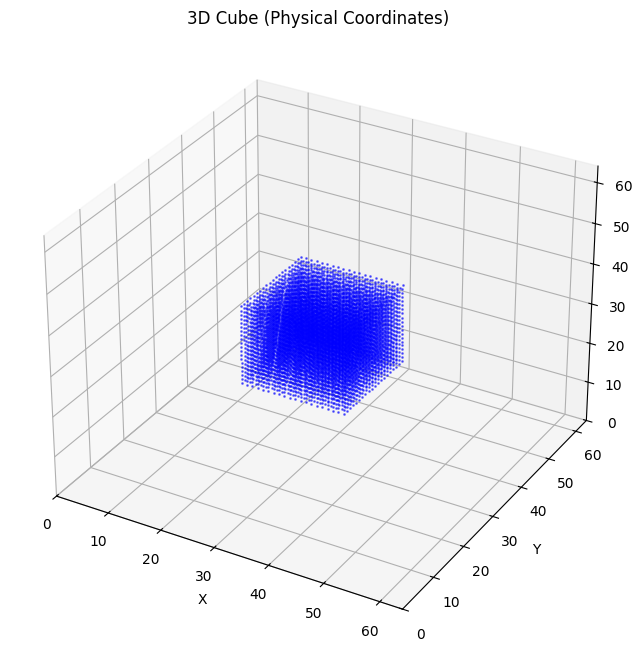

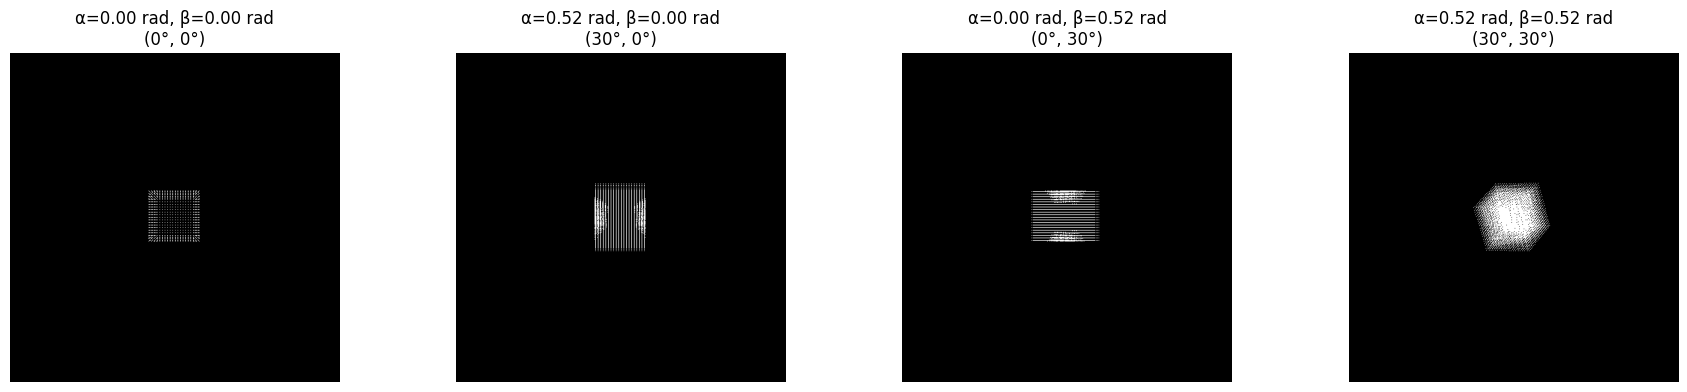

In [30]:
def create_test_cube(volume_shape, cube_size=10):
    volume = torch.zeros(volume_shape, device=device)
    center = torch.tensor(volume_shape)//2
    half = cube_size//2
    volume[
        center[0]-half:center[0]+half,
        center[1]-half:center[1]+half,
        center[2]-half:center[2]+half
    ] = 1
    return volume

# Parameters (in mm)
volume_shape = (64, 64, 64)
image_shape = (512, 512)
pixel_spacing = (0.5, 0.5)
SOD = 500.0
SID = 1000.0

projector = XRayProjector(volume_shape, image_shape, pixel_spacing, SOD, SID)
test_cube = create_test_cube(volume_shape, cube_size=20)

# 3D visualization
def plot_3d_cube(cube):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    coords = torch.nonzero(cube).cpu().numpy()
    if len(coords) > 0:
        # Plot voxels as small cubes for better visualization
        for x, y, z in coords:
            ax.scatter(x, y, z, color='blue', s=1, alpha=0.5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Cube (Physical Coordinates)')
    ax.set_xlim(0, volume_shape[0])
    ax.set_ylim(0, volume_shape[1])
    ax.set_zlim(0, volume_shape[2])
    plt.show()

plot_3d_cube(test_cube)

# Project from different angles
angles = [
    (0, 0),          # Front view
    (math.pi/6, 0),  # 30° around x-axis
    (0, math.pi/6),  # 30° around y-axis
    (math.pi/6, math.pi/6)  # 30° around both
]

fig, axes = plt.subplots(1, len(angles), figsize=(18, 4))
for i, (alpha, beta) in enumerate(angles):
    proj_image = projector.project_volume(test_cube, alpha, beta)
    axes[i].imshow(proj_image.cpu().numpy(), cmap='gray')
    axes[i].set_title(f'α={alpha:.2f} rad, β={beta:.2f} rad\n({math.degrees(alpha):.0f}°, {math.degrees(beta):.0f}°)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 2. Matrix-based Projection

In [7]:
class MatrixXRayProjector:
    def __init__(self, volume_shape, image_shape, pixel_spacing, SOD, SID):
        """
        Matrix-based implementation of the projection operator Π_k(X) = P·vec(X)
        
        Args:
            volume_shape: (m,n,p) or (n,n,n) - 3D volume dimensions
            image_shape: (h,w) - 2D detector dimensions
            pixel_spacing: (dx,dy) - Pixel spacing in mm 
            SOD: Source-to-Isocenter Distance in mm 
            SID: Source-to-Detector Distance in mm 
        """
        self.volume_shape = volume_shape
        self.image_shape = image_shape
        self.pixel_spacing = torch.tensor(pixel_spacing, device=device)
        self.SOD = SOD
        self.SID = SID
        
        # Precompute all possible voxel coordinates
        z, y, x = torch.meshgrid(
            torch.arange(volume_shape[0], device=device),
            torch.arange(volume_shape[1], device=device),
            torch.arange(volume_shape[2], device=device),
            indexing='ij'
        )
        self.voxel_coords = torch.stack((x, y, z), dim=-1).float() - torch.tensor(volume_shape, device=device)//2
        
    def get_rotation_matrix(self, alpha, beta):
        """Same rotation matrix as before"""
        cos_a, sin_a = math.cos(alpha), math.sin(alpha)
        cos_b, sin_b = math.cos(beta), math.sin(beta)
    
        return torch.tensor([
            [cos_b,         sin_b*sin_a,      sin_b*cos_a],
            [0,             cos_a,            -sin_a],
            [-sin_b,        cos_b*sin_a,      cos_b*cos_a]
        ], device=device)
    
    def build_projection_matrix(self, alpha, beta):
        """
        Build the sparse projection matrix P for given angles
        
        Returns:
            P: Sparse matrix of shape (h*w, m*n*p) where P[i*w+j, :] corresponds to pixel (i,j)
        """
        h, w = self.image_shape
        m, n, p = self.volume_shape
        total_pixels = h * w
        total_voxels = m * n * p
        
        # Initialize lists for sparse matrix construction
        row_indices = []
        col_indices = []
        
        # Apply rotation to all voxels
        R = self.get_rotation_matrix(alpha, beta)
        rotated_coords = torch.matmul(self.voxel_coords, R.T)
        
        # Perspective projection
        proj_coords = rotated_coords.clone()
        proj_coords[..., 2] += self.SOD
        
        # Only consider points in front of the detector
        valid_mask = proj_coords[..., 2] > 0
        valid_voxels = torch.nonzero(valid_mask)
        
        # Project valid voxels
        det_coords = (proj_coords[valid_mask][..., :2] / 
                     proj_coords[valid_mask][..., 2].unsqueeze(-1)) * self.SID
        
        # Convert to pixel coordinates
        pixel_coords = det_coords / self.pixel_spacing + torch.tensor([w/2, h/2], device=device)
        pixel_coords = pixel_coords.round().long()
        
        # Filter valid pixels
        pixel_valid = (
            (pixel_coords[:, 0] >= 0) & 
            (pixel_coords[:, 0] < w) & 
            (pixel_coords[:, 1] >= 0) & 
            (pixel_coords[:, 1] < h))
        
        valid_pixel_coords = pixel_coords[pixel_valid]
        valid_voxel_indices = valid_voxels[pixel_valid]
        
        # Convert voxel indices to linear indices
        voxel_linear_indices = (
            valid_voxel_indices[:, 0] * n * p + 
            valid_voxel_indices[:, 1] * p + 
            valid_voxel_indices[:, 2])
        
        # Convert pixel coordinates to linear indices
        pixel_linear_indices = (
            valid_pixel_coords[:, 1] * w + 
            valid_pixel_coords[:, 0])
        
        # Create sparse matrix
        indices = torch.stack([pixel_linear_indices, voxel_linear_indices], dim=0)
        values = torch.ones(len(pixel_linear_indices), device=device)
        
        P = torch.sparse_coo_tensor(
            indices, 
            values, 
            size=(total_pixels, total_voxels),
            device=device
        )
        
        return P
    
    def project_volume(self, X, alpha, beta):
        """
        Project using sparse matrix multiplication: Π_k(X) = P·vec(X)
        
        Args:
            X: Binary 3D volume tensor (m,n,p)
            alpha: Primary angle in radians
            beta: Secondary angle in radians
            
        Returns:
            Projected 2D binary image I_k (h,w)
        """
        # Build or get cached projection matrix
        P = self.build_projection_matrix(alpha, beta)
        
        # Vectorize input
        vec_X = X.flatten().float()
        
        # Sparse matrix multiplication
        proj_vec = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
        
        # Reshape and binarize
        proj_image = (proj_vec > 0).reshape(self.image_shape)
        
        return proj_image

### 3. Performance Comparison

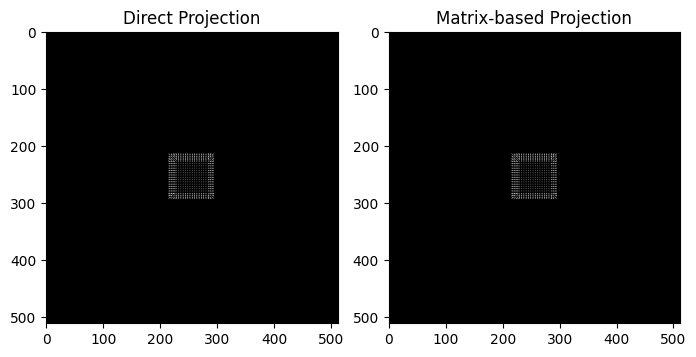

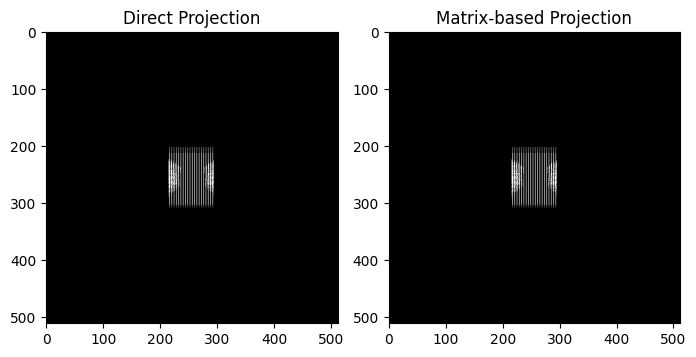

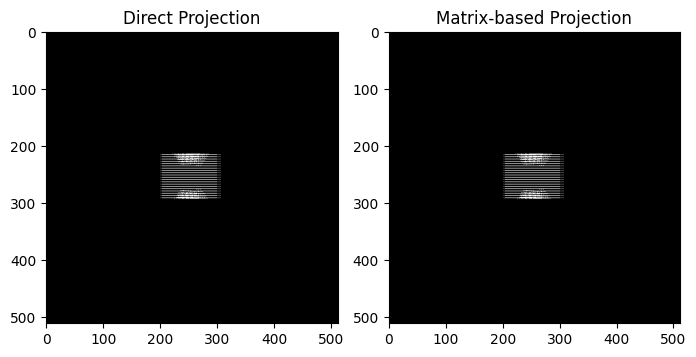

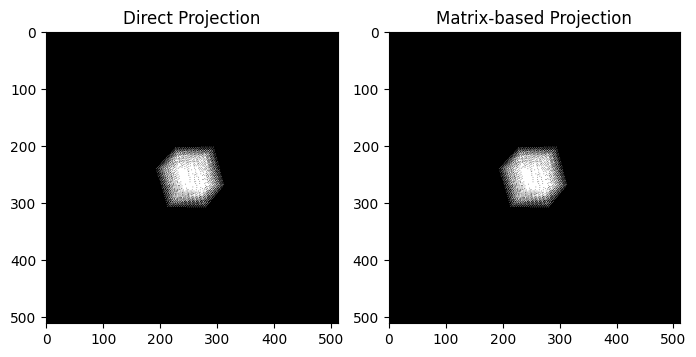


=== Final Performance Comparison ===
Volume size: (64, 64, 64)
α (rad)    β (rad)    Direct Projection Time Matrix-based Projection Time
0.00       0.00       0.0160       0.0270      
0.52       0.00       0.0010       0.0035      
0.00       0.52       0.0010       0.0030      
0.52       0.52       0.0020       0.0030      


In [29]:
# Create both projectors
voxel_projector = XRayProjector(volume_shape, image_shape, pixel_spacing, SOD, SID)
matrix_projector = MatrixXRayProjector(volume_shape, image_shape, pixel_spacing, SOD, SID)

# Test angles
test_angles = [
    (0, 0),          # Front view
    (math.pi/6, 0),  # 30° around x-axis
    (0, math.pi/6),  # 30° around y-axis
    (math.pi/6, math.pi/6)  # 30° around both
]

# Warm-up runs (to account for any one-time initialization)
for alpha, beta in test_angles:
    _ = voxel_projector.project_volume(test_cube, alpha, beta)
    _ = matrix_projector.project_volume(test_cube, alpha, beta)

# Accuracy and performance comparison
results = []
for alpha, beta in test_angles:
    # Time of direct projection method
    start = time.time()
    voxel_proj = voxel_projector.project_volume(test_cube, alpha, beta)
    voxel_time = time.time() - start
    
    # Time of matrix-based method (including matrix construction)
    start = time.time()
    matrix_proj = matrix_projector.project_volume(test_cube, alpha, beta)
    matrix_time = time.time() - start
    
    results.append({
        'alpha': alpha,
        'beta': beta,
        'voxel_time': voxel_time,
        'matrix_time': matrix_time
    })

    voxel_proj = voxel_projector.project_volume(test_cube, alpha, beta)
    matrix_proj = matrix_projector.project_volume(test_cube, alpha, beta)

    fig, axes = plt.subplots(1, 2, figsize=(7, 5))
    axes[0].imshow(voxel_proj.cpu().numpy(), cmap='gray')
    axes[0].set_title('Direct Projection')
    axes[1].imshow(matrix_proj.cpu().numpy(), cmap='gray')
    axes[1].set_title('Matrix-based Projection')
    plt.tight_layout()
    plt.show()

# Print comparison results
print("\n=== Final Performance Comparison ===")
print(f"Volume size: {volume_shape}")
print("{:<10} {:<10} {:<12} {:<12}".format(
    "α (rad)", "β (rad)", "Direct Projection Time", "Matrix-based Projection Time"))
for res in results:
    print("{:<10.2f} {:<10.2f} {:<12.4f} {:<12.4f}".format(
        res['alpha'], res['beta'], 
        res['voxel_time'], res['matrix_time']))